In [ ]:
# Required additional libraries to run code in Google Colab Enviourment
#%pip install tensorflow
#%pip install matplotlib
#%pip install keras-tuner

# LSTM:

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load the stock price data
stock_price_file = "/content/MSFT_2007-2016.csv"
sentiment_file = '/content/final_complete_MSFT_sentiment.csv'
stock_price_data = pd.read_csv(stock_price_file)
sentiment_data = pd.read_csv(sentiment_file)

# Preprocess the stock price data
stock_price_data['Date'] = pd.to_datetime(stock_price_data['Date'], utc=True)
stock_price_data['Date'] = stock_price_data['Date'].dt.tz_localize(None)  # Remove time zone information
stock_price_data['Date'] = stock_price_data['Date'].dt.date  # Keep only the date part

# Preprocess the sentiment data
sentiment_data['ts'] = pd.to_datetime(sentiment_data['ts'], utc=True)
sentiment_data['ts'] = sentiment_data['ts'].dt.date  # Keep only the date part
sentiment_data.rename(columns={'ts': 'Date'}, inplace=True)

# Set the date as index for both DataFrames
stock_price_data.set_index('Date', inplace=True)
sentiment_data.set_index('Date', inplace=True)

# Join the stock price data with the sentiment data
merged_data = stock_price_data.join(sentiment_data, how='inner')  # Inner join to keep only matching dates

# Select 'Close' feature and normalize for univariate model
close_prices = merged_data[['Close']].values
scaler_close = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler_close.fit_transform(close_prices)

# Convert an array of values into a dataset matrix for multivariate data
def create_dataset_mv(dataset, input_time_steps=5, output_time_steps=5):
    X, y = [], []
    for i in range(len(dataset) - input_time_steps - output_time_steps + 1):
        X.append(dataset[i:(i + input_time_steps), :])
        y.append(dataset[(i + input_time_steps):(i + input_time_steps + output_time_steps), 0])  # Target is 'Close' price
    return np.array(X), np.array(y)


# Select 'Close' feature and normalize
close_prices = merged_data[['Close']].values
scaler_close = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler_close.fit_transform(close_prices)

# Select features for multivariate model ('Close' and 'Average_sentiment')
features_with_sentiment = merged_data[['Close', 'Average_sentiment']].values
scaler_multi = MinMaxScaler(feature_range=(0, 1))
features_with_sentiment_scaled = scaler_multi.fit_transform(features_with_sentiment)

# Define the time_steps for input and output
input_time_steps = 5
output_time_steps = 5

# Create datasets
X_uni, y_uni = create_dataset_mv(close_prices_scaled, input_time_steps, output_time_steps)
X_multi, y_multi = create_dataset_mv(features_with_sentiment_scaled, input_time_steps, output_time_steps)

# Reshape data for LSTM input
X_uni = X_uni.reshape(X_uni.shape[0], 5, 1)
X_multi = X_multi.reshape(X_multi.shape[0], 5, 2)


# Splitting datasets into train and test sets
train_size_uni = int(len(X_uni) * 0.70)
X_train_uni, y_train_uni = X_uni[:train_size_uni], y_uni[:train_size_uni]
X_test_uni, y_test_uni = X_uni[train_size_uni:], y_uni[train_size_uni:]

# Further split the training data into training and validation sets for Univariate
val_size_uni = int(len(X_train_uni) * 0.2)
X_val_uni, y_val_uni = X_train_uni[-val_size_uni:], y_train_uni[-val_size_uni:]
X_train_uni, y_train_uni = X_train_uni[:-val_size_uni], y_train_uni[:-val_size_uni]

train_size_multi = int(len(X_multi) * 0.70)
X_train_multi, y_train_multi = X_multi[:train_size_multi], y_multi[:train_size_multi]
X_test_multi, y_test_multi = X_multi[train_size_multi:], y_multi[train_size_multi:]

# Further split the multivariate training data into training and validation sets
val_size_multi = int(len(X_train_multi) * 0.2)
X_val_multi, y_val_multi = X_train_multi[-val_size_multi:], y_train_multi[-val_size_multi:]
X_train_multi, y_train_multi = X_train_multi[:-val_size_multi], y_train_multi[:-val_size_multi]

# Define the univariate LSTM model
def build_uni_model(input_shape=(input_time_steps, 1 ), output_units=output_time_steps):
    model = Sequential()
    # First LSTM layer with 100 units and return sequences set to True
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    # Second LSTM layer with 50 units, with return sequences set to False
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.5))
    # Output layer with 'output_units' neurons to predict the next 'output_time_steps' days
    model.add(Dense(units=output_units))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    return model


# Define the multivariate LSTM model
def build_mv_model(input_shape=(input_time_steps, 2 ), output_units=output_time_steps):
    model = Sequential()
    # First LSTM layer with 100 units and return sequences set to True
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    # Second LSTM layer with 50 units, also with return sequences set to True
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.5))
    # Output layer with 'output_units' neurons to predict the next 'output_time_steps' days
    model.add(Dense(units=output_units))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    return model

#Build Models
model_uni = build_uni_model()
model_multi = build_mv_model()

# Use ReduceLROnPlateau to reduce learning rate when the metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.000001, cooldown=0, min_lr=0
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train models
history_uni = model_uni.fit(
    X_train_uni, y_train_uni,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_uni, y_val_uni),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)


history_multi = model_multi.fit(
    X_train_multi, y_train_multi,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)



def evaluate_model(model, X, y, scaler, is_univariate):
    # Make predictions
    predictions = model.predict(X)

    if is_univariate:
        # For univariate data, directly inverse transform the predictions
        predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, output_time_steps)
        y_inverse = scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1, output_time_steps)
    else:
        # For multivariate data, reshape and inverse transform
        # Concatenate a dummy feature for inverse transformation
        predictions_stacked = np.concatenate([predictions, np.zeros(predictions.shape)], axis=-1)
        predictions_reshaped = predictions_stacked.reshape(-1, 2)  # Reshaping for inverse transformation
        predictions_inverse_reshaped = scaler.inverse_transform(predictions_reshaped)[:, 0]  # Inverse transform and extract the 'Close' prices
        predictions_inverse = predictions_inverse_reshaped.reshape(-1, output_time_steps)  # Reshape back to the original format

        # Prepare y for comparison
        y_stacked = np.concatenate([y, np.zeros(y.shape)], axis=-1)
        y_reshaped = y_stacked.reshape(-1, 2)
        y_inverse = scaler.inverse_transform(y_reshaped)[:, 0].reshape(-1, output_time_steps)

    # Calculate RMSE, MAPE, and Pearson's R
    rmse = np.sqrt(mean_squared_error(y_inverse.flatten(), predictions_inverse.flatten()))
    epsilon = np.finfo(float).eps
    mape = np.mean(np.abs((y_inverse.flatten() - predictions_inverse.flatten()) / np.maximum(y_inverse.flatten(), epsilon))) * 100
    r = pearsonr(y_inverse.flatten(), predictions_inverse.flatten())[0]

    return rmse, mape, r

# Evaluate the multivariate model (with sentiment)
avg_rmse_multi, avg_mape_multi, r_multi = evaluate_model(model_multi, X_test_multi, y_test_multi, scaler_multi, is_univariate=False)
print(f"Multivariate LSTM Model (With Sentiment) - RMSE: {avg_rmse_multi}, MAPE: {avg_mape_multi}, Pearson's R: {r_multi}")

# Evaluate the univariate model (without sentiment)
# Note: For univariate, reshape y_test_uni to match the expected output shape
y_test_uni_reshaped = y_test_uni.reshape(y_test_uni.shape[0], y_test_uni.shape[1], 1)
avg_rmse_uni, avg_mape_uni, r_uni = evaluate_model(model_uni, X_test_uni, y_test_uni_reshaped, scaler_close, is_univariate=True)
print(f"Univariate LSTM Model (Without Sentiment) - RMSE: {avg_rmse_uni}, MAPE: {avg_mape_uni}, Pearson's R: {r_uni}")



Epoch 1/50
151/151 [==============================] - 9s 10ms/step - loss: 0.0451 - val_loss: 0.0837 - lr: 1.0000e-05
Epoch 2/50
151/151 [==============================] - 1s 5ms/step - loss: 0.0402 - val_loss: 0.0753 - lr: 1.0000e-05
Epoch 3/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0352 - val_loss: 0.0660 - lr: 1.0000e-05
Epoch 4/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0297 - val_loss: 0.0557 - lr: 1.0000e-05
Epoch 5/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0236 - val_loss: 0.0442 - lr: 1.0000e-05
Epoch 6/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0181 - val_loss: 0.0328 - lr: 1.0000e-05
Epoch 7/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0129 - val_loss: 0.0224 - lr: 1.0000e-05
Epoch 8/50
151/151 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 0.0148 - lr: 1.0000e-05
Epoch 9/50
151/151 [==============================] - 1s 8ms/st

21/21 [==============================] - 0s 3ms/step


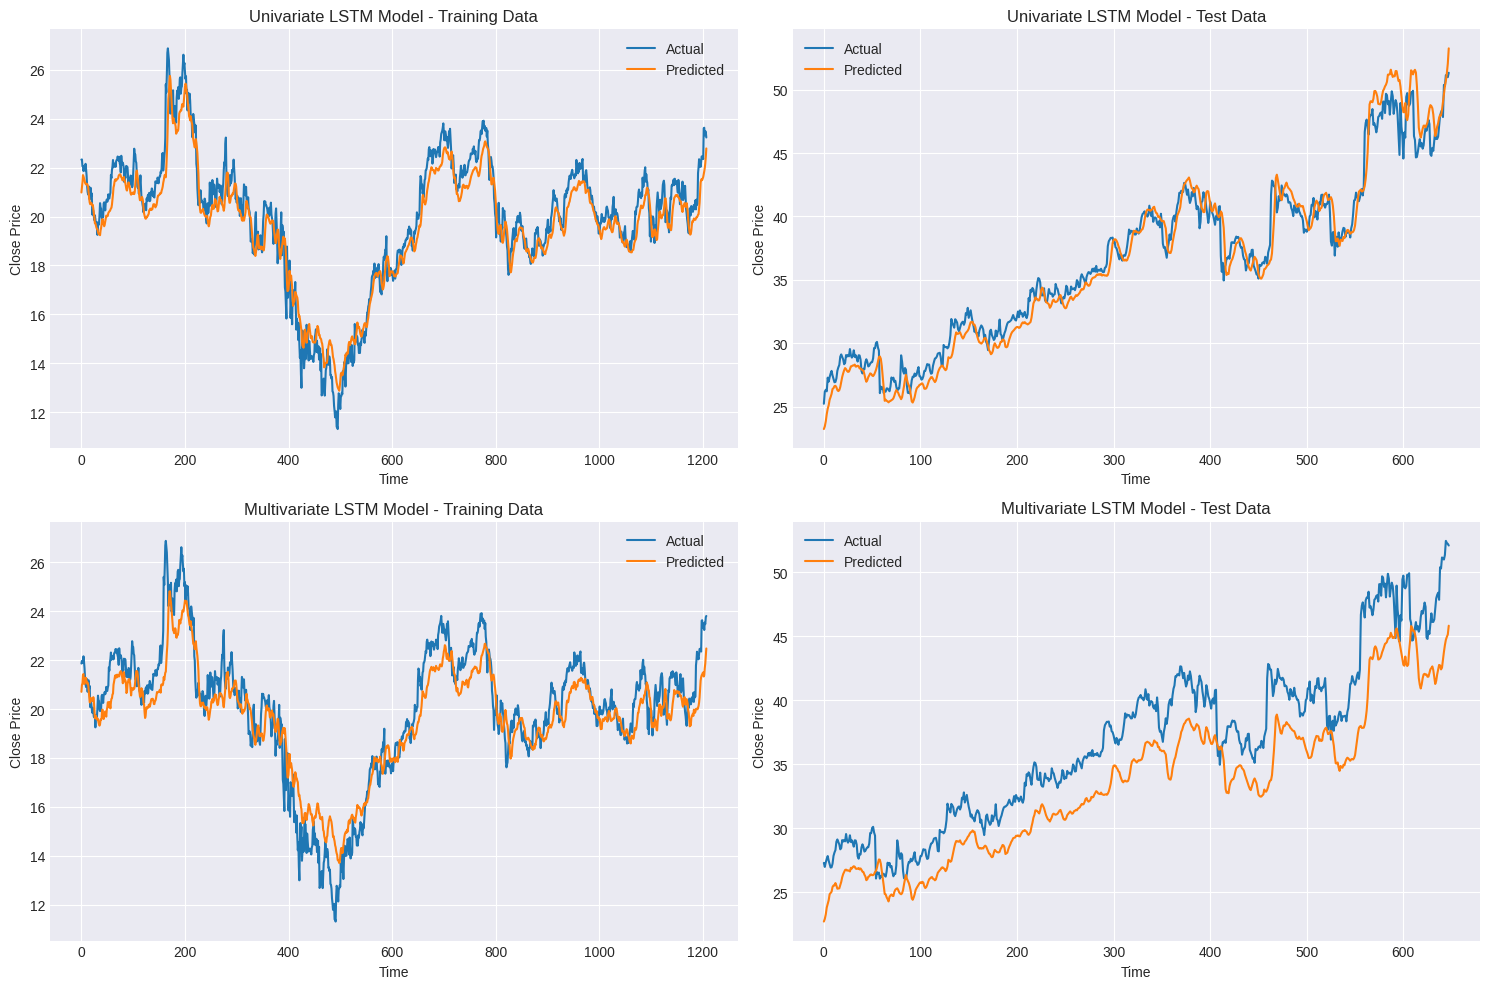

In [52]:
# Plotting
plt.figure(figsize=(15, 10))

# Univariate Model - Training Data Plot
plt.subplot(2, 2, 1)
actual_uni_train = scaler_close.inverse_transform(y_train_uni[:, 0].reshape(-1, 1)).flatten()
predicted_uni_train = scaler_close.inverse_transform(model_uni.predict(X_train_uni)[:, 0].reshape(-1, 1)).flatten()
plt.plot(actual_uni_train, label='Actual')
plt.plot(predicted_uni_train, label='Predicted')
plt.title('Univariate LSTM Model - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Univariate Model - Test Data Plot
plt.subplot(2, 2, 2)
actual_uni_test = scaler_close.inverse_transform(y_test_uni[:, 0].reshape(-1, 1)).flatten()
predicted_uni_test = scaler_close.inverse_transform(model_uni.predict(X_test_uni)[:, 0].reshape(-1, 1)).flatten()
plt.plot(actual_uni_test, label='Actual')
plt.plot(predicted_uni_test, label='Predicted')
plt.title('Univariate LSTM Model - Test Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Multivariate Model - Training Data
plt.subplot(2, 2, 3)
# Predict the training data
predicted_multi_train = model_multi.predict(X_train_multi)
# Extract the last day prediction for each input sequence
predicted_multi_train_last = predicted_multi_train[:, -1]
# Inverse transform the predictions to the original scale
predicted_multi_train_last_inversed = scaler_close.inverse_transform(predicted_multi_train_last.reshape(-1, 1)).flatten()

# Get the actual values for the last day in the output sequence for the training data
actual_multi_train_last = y_train_multi[:, -1]
actual_multi_train_last_inversed = scaler_close.inverse_transform(actual_multi_train_last.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.plot(actual_multi_train_last_inversed, label='Actual')
plt.plot(predicted_multi_train_last_inversed, label='Predicted')
plt.title('Multivariate LSTM Model - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Multivariate Model - Test Data
plt.subplot(2, 2, 4)
# Predict the test data
predicted_multi_test = model_multi.predict(X_test_multi)
# Extract the last day prediction for each input sequence
predicted_multi_test_last = predicted_multi_test[:, -1]
# Inverse transform the predictions to the original scale
predicted_multi_test_last_inversed = scaler_close.inverse_transform(predicted_multi_test_last.reshape(-1, 1)).flatten()

# Get the actual values for the last day in the output sequence for the test data
actual_multi_test_last = y_test_multi[:, -1]
actual_multi_test_last_inversed = scaler_close.inverse_transform(actual_multi_test_last.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.plot(actual_multi_test_last_inversed, label='Actual')
plt.plot(predicted_multi_test_last_inversed, label='Predicted')
plt.title('Multivariate LSTM Model - Test Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()

# GRU:

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from tensorflow.keras.callbacks import EarlyStopping
import math

# Load the stock price data
stock_price_file = "/content/MSFT_2007-2016.csv"
sentiment_file = '/content/final_complete_MSFT_sentiment.csv'
stock_price_data = pd.read_csv(stock_price_file)
sentiment_data = pd.read_csv(sentiment_file)

# Preprocess the stock price data
stock_price_data['Date'] = pd.to_datetime(stock_price_data['Date'], utc=True)
stock_price_data['Date'] = stock_price_data['Date'].dt.tz_localize(None)  # Remove time zone information
stock_price_data['Date'] = stock_price_data['Date'].dt.date  # Keep only the date part

# Preprocess the sentiment data
sentiment_data['ts'] = pd.to_datetime(sentiment_data['ts'], utc=True)
sentiment_data['ts'] = sentiment_data['ts'].dt.date  # Keep only the date part
sentiment_data.rename(columns={'ts': 'Date'}, inplace=True)

# Set the date as index for both DataFrames
stock_price_data.set_index('Date', inplace=True)
sentiment_data.set_index('Date', inplace=True)

# Join the stock price data with the sentiment data
merged_data = stock_price_data.join(sentiment_data, how='inner')  # Inner join to keep only matching dates

# Select 'Close' feature and normalize for univariate model
close_prices = merged_data[['Close']].values
scaler_close = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler_close.fit_transform(close_prices)


# Convert an array of values into a dataset matrix for multivariate data
def create_dataset_mv(dataset, input_time_steps=5, output_time_steps=5):
    X, y = [], []
    for i in range(len(dataset) - input_time_steps - output_time_steps + 1):
        X.append(dataset[i:(i + input_time_steps), :])
        y.append(dataset[(i + input_time_steps):(i + input_time_steps + output_time_steps), 0])  # Target is 'Close' price
    return np.array(X), np.array(y)


# Select 'Close' feature and normalize
close_prices = merged_data[['Close']].values
scaler_close = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler_close.fit_transform(close_prices)

# Select features for multivariate model ('Close' and 'Average_sentiment')
features_with_sentiment = merged_data[['Close', 'Average_sentiment']].values
scaler_multi = MinMaxScaler(feature_range=(0, 1))
features_with_sentiment_scaled = scaler_multi.fit_transform(features_with_sentiment)

# Define the time_steps for input and output
input_time_steps = 5
output_time_steps = 5

# Create datasets
X_uni, y_uni = create_dataset_mv(close_prices_scaled, input_time_steps, output_time_steps)
X_multi, y_multi = create_dataset_mv(features_with_sentiment_scaled, input_time_steps, output_time_steps)

# Reshape data for model input
X_uni = X_uni.reshape(X_uni.shape[0], 5, 1)
X_multi = X_multi.reshape(X_multi.shape[0], 5, 2)

# Splitting datasets into train and test sets
train_size_uni = int(len(X_uni) * 0.70)
X_train_uni, y_train_uni = X_uni[:train_size_uni], y_uni[:train_size_uni]
X_test_uni, y_test_uni = X_uni[train_size_uni:], y_uni[train_size_uni:]

# Further split the training data into training and validation sets for Univariate
val_size_uni = int(len(X_train_uni) * 0.2)
X_val_uni, y_val_uni = X_train_uni[-val_size_uni:], y_train_uni[-val_size_uni:]
X_train_uni, y_train_uni = X_train_uni[:-val_size_uni], y_train_uni[:-val_size_uni]

# Further split the training data into training and validation sets for Multivariate
train_size_multi = int(len(X_multi) * 0.70)
X_train_multi, y_train_multi = X_multi[:train_size_multi], y_multi[:train_size_multi]
X_test_multi, y_test_multi = X_multi[train_size_multi:], y_multi[train_size_multi:]

# Further split the multivariate training data into training and validation sets
val_size_multi = int(len(X_train_multi) * 0.2)
X_val_multi, y_val_multi = X_train_multi[-val_size_multi:], y_train_multi[-val_size_multi:]
X_train_multi, y_train_multi = X_train_multi[:-val_size_multi], y_train_multi[:-val_size_multi]

# Defining the univariate GRU model
def build_uni_model(input_shape=(input_time_steps, 1 ), output_units=output_time_steps):
    model = Sequential()
    # First GRU layer with 100 units and return sequences set to True
    model.add(GRU(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    # Second GRU layer with 50 units, with return sequences set to False
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.5))
    # Output layer with 'output_units' neurons to predict the next 'output_time_steps' days
    model.add(Dense(units=output_units))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    return model


# Define the multivariate GRU model with the updated architecture
def build_mv_model(input_shape=(input_time_steps, 2 ), output_units=output_time_steps):
    model = Sequential()
    # First GRU layer with 100 units and return sequences set to True
    model.add(GRU(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    # Second GRU layer with 50 units, with return sequences set to False
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.5))
    # Output layer with 'output_units' neurons to predict the next 'output_time_steps' days
    model.add(Dense(units=output_units))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    return model

#Build Models
model_uni = build_uni_model()
model_multi = build_mv_model()

# Use ReduceLROnPlateau to reduce learning rate when the metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto',
    min_delta=0.000001, cooldown=0, min_lr=0
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training Univariate model
history_uni = model_uni.fit(
    X_train_uni, y_train_uni,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_uni, y_val_uni),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

#Training Multivariate model
history_multi = model_multi.fit(
    X_train_multi, y_train_multi,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)


def evaluate_model(model, X, y, scaler, is_univariate):
    # Make predictions
    predictions = model.predict(X)

    if is_univariate:
        # For univariate data, directly inverse transform the predictions
        predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1, output_time_steps)
        y_inverse = scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1, output_time_steps)
    else:
        # For multivariate data, reshape and inverse transform
        # Concatenate a dummy feature for inverse transformation
        predictions_stacked = np.concatenate([predictions, np.zeros(predictions.shape)], axis=-1)
        predictions_reshaped = predictions_stacked.reshape(-1, 2)  # Reshaping for inverse transformation
        predictions_inverse_reshaped = scaler.inverse_transform(predictions_reshaped)[:, 0]  # Inverse transform and extract the 'Close' prices
        predictions_inverse = predictions_inverse_reshaped.reshape(-1, output_time_steps)  # Reshape back to the original format

        # Prepare y for comparison
        y_stacked = np.concatenate([y, np.zeros(y.shape)], axis=-1)
        y_reshaped = y_stacked.reshape(-1, 2)
        y_inverse = scaler.inverse_transform(y_reshaped)[:, 0].reshape(-1, output_time_steps)

    # Calculate RMSE, MAPE, and Pearson's R
    rmse = np.sqrt(mean_squared_error(y_inverse.flatten(), predictions_inverse.flatten()))
    epsilon = np.finfo(float).eps
    mape = np.mean(np.abs((y_inverse.flatten() - predictions_inverse.flatten()) / np.maximum(y_inverse.flatten(), epsilon))) * 100
    r = pearsonr(y_inverse.flatten(), predictions_inverse.flatten())[0]

    return rmse, mape, r

# Evaluate the multivariate LSTM model (with sentiment)
avg_rmse_multi, avg_mape_multi, r_multi = evaluate_model(model_multi, X_test_multi, y_test_multi, scaler_multi, is_univariate=False)
print(f"Multivariate GRU Model (With Sentiment) - RMSE: {avg_rmse_multi}, MAPE: {avg_mape_multi}, Pearson's R: {r_multi}")

# Evaluate the univariate LSTM model (without sentiment)
# Note: For univariate, reshape y_test_uni to match the expected output shape
y_test_uni_reshaped = y_test_uni.reshape(y_test_uni.shape[0], y_test_uni.shape[1], 1)
avg_rmse_uni, avg_mape_uni, r_uni = evaluate_model(model_uni, X_test_uni, y_test_uni_reshaped, scaler_close, is_univariate=True)
print(f"Univariate GRU Model (Without Sentiment) - RMSE: {avg_rmse_uni}, MAPE: {avg_mape_uni}, Pearson's R: {r_uni}")




Epoch 1/50
151/151 [==============================] - 5s 12ms/step - loss: 0.0450 - val_loss: 0.0780 - lr: 1.0000e-05
Epoch 2/50
151/151 [==============================] - 1s 7ms/step - loss: 0.0351 - val_loss: 0.0619 - lr: 1.0000e-05
Epoch 3/50
151/151 [==============================] - 1s 7ms/step - loss: 0.0265 - val_loss: 0.0474 - lr: 1.0000e-05
Epoch 4/50
151/151 [==============================] - 1s 7ms/step - loss: 0.0196 - val_loss: 0.0347 - lr: 1.0000e-05
Epoch 5/50
151/151 [==============================] - 1s 7ms/step - loss: 0.0148 - val_loss: 0.0244 - lr: 1.0000e-05
Epoch 6/50
151/151 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0172 - lr: 1.0000e-05
Epoch 7/50
151/151 [==============================] - 1s 9ms/step - loss: 0.0092 - val_loss: 0.0123 - lr: 1.0000e-05
Epoch 8/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0082 - val_loss: 0.0096 - lr: 1.0000e-05
Epoch 9/50
151/151 [==============================] - 1s 8ms/s

21/21 [==============================] - 0s 3ms/step


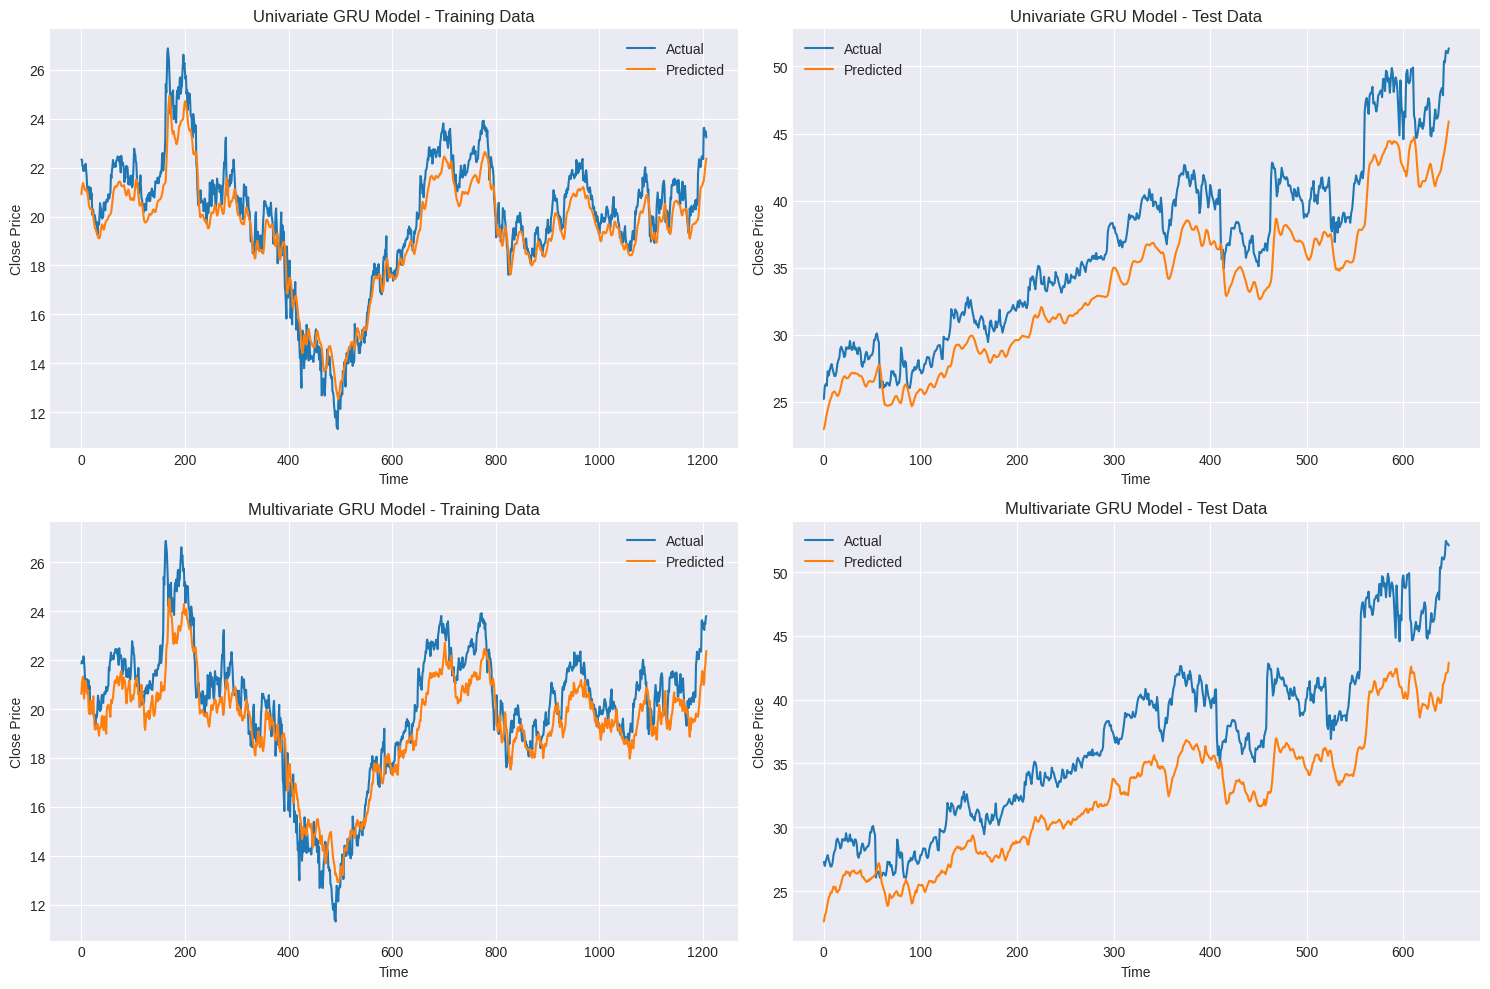

In [54]:
# Plotting
plt.figure(figsize=(15, 10))

# Univariate Model - Training Data Plot
plt.subplot(2, 2, 1)
actual_uni_train = scaler_close.inverse_transform(y_train_uni[:, 0].reshape(-1, 1)).flatten()
predicted_uni_train = scaler_close.inverse_transform(model_uni.predict(X_train_uni)[:, 0].reshape(-1, 1)).flatten()
plt.plot(actual_uni_train, label='Actual')
plt.plot(predicted_uni_train, label='Predicted')
plt.title('Univariate GRU Model - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Univariate Model - Test Data Plot
plt.subplot(2, 2, 2)
actual_uni_test = scaler_close.inverse_transform(y_test_uni[:, 0].reshape(-1, 1)).flatten()
predicted_uni_test = scaler_close.inverse_transform(model_uni.predict(X_test_uni)[:, 0].reshape(-1, 1)).flatten()
plt.plot(actual_uni_test, label='Actual')
plt.plot(predicted_uni_test, label='Predicted')
plt.title('Univariate GRU Model - Test Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Multivariate Model - Training Data
plt.subplot(2, 2, 3)
# Predict the training data
predicted_multi_train = model_multi.predict(X_train_multi)
# Extract the last day prediction for each input sequence
predicted_multi_train_last = predicted_multi_train[:, -1]
# Inverse transform the predictions to the original scale
predicted_multi_train_last_inversed = scaler_close.inverse_transform(predicted_multi_train_last.reshape(-1, 1)).flatten()

# Get the actual values for the last day in the output sequence for the training data
actual_multi_train_last = y_train_multi[:, -1]
actual_multi_train_last_inversed = scaler_close.inverse_transform(actual_multi_train_last.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.plot(actual_multi_train_last_inversed, label='Actual')
plt.plot(predicted_multi_train_last_inversed, label='Predicted')
plt.title('Multivariate GRU Model - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

# Multivariate Model - Test Data
plt.subplot(2, 2, 4)
# Predict the test data
predicted_multi_test = model_multi.predict(X_test_multi)
# Extract the last day prediction for each input sequence
predicted_multi_test_last = predicted_multi_test[:, -1]
# Inverse transform the predictions to the original scale
predicted_multi_test_last_inversed = scaler_close.inverse_transform(predicted_multi_test_last.reshape(-1, 1)).flatten()

# Get the actual values for the last day in the output sequence for the test data
actual_multi_test_last = y_test_multi[:, -1]
actual_multi_test_last_inversed = scaler_close.inverse_transform(actual_multi_test_last.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.plot(actual_multi_test_last_inversed, label='Actual')
plt.plot(predicted_multi_test_last_inversed, label='Predicted')
plt.title('Multivariate GRU Model - Test Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()